<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Bias correction of seasonal forecast data

### About

This notebook will show you how you can bias correct real-time seasonal forecasts of global sea surface temperature. 

#### Model errors
Seasonal forecasts are started from an observed state of (all components of) the climate system, which is then evolved in time over a period of a few months. Errors present at the start of the forecast (due to the imprecise measurement of the initial conditions and the approximations assumed in the formulation of the models) persist or, more often, grow through the model integration.

#### Biases and hindcasts
Some errors are random, some errors, however, are systematic. If these systematic errors were determined, corrections could be applied to the forecasts to extract the useful information. This is achieved by comparing retrospective forecasts (reforecasts or `hindcasts`) with observations. By building the average of the `hindcasts`, you can identify a 'climate' (average over a reference period, e.g 1993 to 2016) of the model, which can then be compared with the observed climate of the real world. The systematic differences between the model and the real world - usually referred to as `biases` - are thus quantified and used as the basis for corrections which can be applied to future, real-time forecasts.  Given the relative magnitude of such biases, some basic corrections are essential to convert the data into forecast information - therefore a forecast by itself is not useful without relating it to the relevant hindcasts.

To compute the real-world climate, the example below will make use of [ERA5 monthly averages on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview).

#### Bias correction
TBA



The notebook has the following outline:

* [1 - Compute the hindcast climate mean and variance for reference period 1993 to 2016](#hindcast_climate_mean_bias)
* [2 - Compute observation climate mean and variance from ERA5 monthly averages for reference period 1993 to 2016](#observation_climate_mean_bias)
* [3 - Load real-time seasonal forecast for September 2021 and five leadtime months](#load_realtime_forecast_bias)
* [4 - Visualize the bias between seasonal real-time forecast, model climate and observed climate](#visualize_bias)
* [5 - Correct the real-time seasonal forecast](#bias_correction)

### Data

This notebook makes use of `seasonal forecast monthly statistics` (hindcasts and real-time forecasts) and `ERA5 monthly averaged data` on single levels. The data used in the notebook has the following specifications:

<br>

> **Data**: `Seasonal forecast monthly statistics on single levels - Hindcast data` <br>
> **Temporal coverage**: `Sep 1993 to Sep 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve requests**: 
> * [CDS API request - Hindcast individual members](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast)
> * [CDS API request - Hindcast climate mean](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast_mean)

<br>

> **Data**: `Seasonal forecast monthly statistics on single levels - Forecast data` <br>
> **Temporal coverage**: `Sep 2021` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#seas5_monthly_forecast)

<br>

> **Data**: `ERA5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Sep, Oct, Nov, Dec, Jan and Feb from 1993 to 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly_seas5)

<br>

Get [here](./101_c3s_data_intro.ipynb#seasonal_forecasts) more information about seasonal forecast data in general including an overview of the different dataset types.

### Further resources

* [Seasonal forecasts and the Copernicus Climate Change Service](https://confluence.ecmwf.int/display/CKB/Seasonal+forecasts+and+the+Copernicus+Climate+Change+Service)

<br>

<hr>

### Load libraries

In [139]:
# CDS API
import cdsapi
import warnings

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for working with dates
from dateutil.relativedelta import relativedelta

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

warnings.simplefilter(action = "ignore", category = RuntimeWarning)

<hr>

## <a id='hindcast_climate_mean_bias'></a>1. Compute the hindcast climate mean and variance for reference period 1993 to 2016

The first step is load the global hindcast data for September from 1993 to 2016 and calculate the `mean` and `variance` of the hindcast climate, based on the reference period 1993 to 2016. 

The seasonal forecasts monthly statistics are available in the data format `GRIB`, which can be opened with the Python package [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()`. In order to be able to open `GRIB` file, you have to specify the keyword argument `engine='cfgrib'`, which makes use of [cfgrib](https://github.com/ecmwf/cfgrib), a Python interface to map GRIB to the NetCDF Common Data model.

You can specify a custom data structure by identifying the keyword argument `backend_kwargs` and specifically highligting the two dimensions that shall be used for the time dimensions. When you do this, you see that the resulting `xarray.Dataset` has five dimensions:
* `number`: Number of ensembles (25)
* `forecastMonth`: leadtime months (6, including the startime run)
* `time`: number of years (24, from 1993 to 2016)
* `latitude`: latitudes (181 -> 1 deg resolution)
* `longitude`: longitudes (360 --> 1 deg resolution)

In [17]:
ds_hindcast = xr.open_dataset('./data/ecmwf_seas5_1993-2016_09_hindcast_monthly.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')), filter_by_keys={'shortName':'sst'})
ds_hindcast

<xarray.Dataset>
Dimensions:        (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    sst            (number, forecastMonth, time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-25T16:17 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

The next step is to load the data variable `sst` as `xarray.DataArray`. You can load a DataArray from a Dataset by specifying the name of the variable in square brackets `[]`. A `xarray.DataArray` provides you additional attributes of the variable. For example, you see that the sea surface temperature is provided in the unit `Kelvin`.

In [6]:
sst_hindcast = ds_hindcast['sst']
sst_hindcast

<xarray.DataArray 'sst' (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)>
[234576000 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sst
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

<br>

Since we are interested in creating the `hindcast climate mean`, the next step is to create the average over the 25 ensemble members and the 24 start years. You can use the function `mean()` in order to average over one or more given dimensions. The dimension we want to create the longterm mean are `number` (25 ensemble members) and `time` (start time years from 1993 to 2016). The result is a `xarray.DataArray` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

The DataArray `tprate_hindcast_mean` is the hindcast climate mean for the month September and five leadtime months, over the reference period 1993 to 2016.

**Note:** with the averaging operation, your `xarray.DataArray` loses its attributes. At the end, we will again add the attributes.

In [7]:
sst_hindcast_mean = sst_hindcast.mean(['number', 'time'])
sst_hindcast_mean

<xarray.DataArray 'sst' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[271.38278, 271.38278, 271.38278, ..., 271.38278, 271.38278,
         271.38278],
        [271.3829 , 271.383  , 271.38315, ..., 271.3826 , 271.38266,
         271.38284],
        [271.38742, 271.38782, 271.38818, ..., 271.3865 , 271.38678,
         271.38702],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.34988, 271.34988, 271.34988, ..., 271.34988, 271.34988,
         271.34988],
        [271.35007, 271.35013, 271.35013, ..., 271.35007, 271.35007,
         271.35007],
        [271.35056, 271.35056, 271.35056, ..., 271.35056, 271.3506 ,
         271.3506 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        [271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        [271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

<br>

The next step is also to calculate the variance of the hindcast climate mean. Instead of the function `mean()`, we can use the function `var()`, which computes the variance over the 25 ensemble members and the 24 start years. The resulting xarray.DataArray `sst_hindcast_variance` has three dimensions: `forecastMonth`, `latitude` and `longitude`. We will need the variance later on when we correct the bias of the forecast data.

In [9]:
sst_hindcast_variance = sst_hindcast.var(['number', 'time'])
sst_hindcast_variance

<xarray.DataArray 'sst' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[1.9864733e-03, 1.9864733e-03, 1.9864733e-03, ...,
         1.9864733e-03, 1.9864733e-03, 1.9864733e-03],
        [2.0455327e-03, 2.0600969e-03, 2.0772023e-03, ...,
         1.9969535e-03, 2.0109811e-03, 2.0267235e-03],
        [2.5749102e-03, 2.6136623e-03, 2.6538339e-03, ...,
         2.4352488e-03, 2.4787856e-03, 2.5270651e-03],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[4.9087776e-06, 4.9087776e-06, 4.9087776e-06, ...,
         4.9087776e-06, 4.9087776e-06, 4.9087776e-06],
        [8.8985144e-06, 8.7972858e-06, 8.7369854e-06, ...,
         8.8633469e-06, 8.8252000e-06, 8.9112300e-06],
        [2.9411360e-05, 2.8977536e-05, 2.8974557e-05, ...,
         2.9754205e-05, 2.9549599e-05, 2.9670397e-05],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        [3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        [3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

<div class="alert alert-block alert-warning">

We will use this later... but we might want to do things differently (see further comments)

</div>

In [174]:
sst_hindcast_lower = sst_hindcast.quantile(0.34,['number', 'time'])
sst_hindcast_upper = sst_hindcast.quantile(0.68,['number', 'time'])


We have now loaded and computed the hindcast climate mean. The next step is to calculate the climate mean from observations, which is used as the observation climate mean.

<br>

## <a id='observation_climate_mean_bias'></a>2. Compute observation climate mean and variance from ERA5 monthly averages for reference period 1993 to 2016

The second step is to compute the climate mean and variance from observations, for the same reference period, from 1993 to 2016. As observation data, we make use of ERA5 monthly averages on single levels.
ERA5 data is a reanalysis and the data structure differs from seasonal forecast data. Instead of leadtime months, we select monthly averages for the months September to February for each year, from 1993 to 2016. See [here](./100_data_store_intro.ipynb#era5_monthly_seas5) the CDS data request used to download the ERA5 monthly averages in GRIB format. You can use the function `open_dataset()` together with the keyword argument `engine='cfgrib'` to open the GRIB file. Here, you do not have to specify specific keys to load, as reanalysis data do not have two time dimensions. If you load the GRIB file, you see that the data is structure in three dimensions: 
* `time`: 144 entries for months Jan, Feb, Sep, Oct, Nov, Dec from 1993 to 2016
* `latitude`: latitude (721 --> 0.25 deg)
* `longitude`: longitude (1440 --> 0.25 deg)

In [10]:
ds_observation = xr.open_dataset('./data/era5_monthly_1993-2016_sep-feb_sst.grib', engine='cfgrib')
ds_observation

<xarray.Dataset>
Dimensions:     (time: 144, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] ...
Data variables:
    sst         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-25T16:14 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

The next step is to load from the dataset above the data variable `sst` as xarray.DataArray. You simply add the name of the data variable in square brackets `[]`.

In [11]:
sst_observation = ds_observation['sst']
sst_observation

<xarray.DataArray 'sst' (time: 144, latitude: 721, longitude: 1440)>
[149506560 values with dtype=float32]
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Attributes: (12/29)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

<br>

The next step is now to create the average for each month for the reference period. You can use the function `group_by()` to specify the dimension you would to build groups from. In the present example, we want to build groups for each month in the `time` dimension. With the function `mean()` you can apply an aggregator function on the defined groups. The resulting data array has three dimensions, but the dimension `time` which has previously 144 entries changed to `month` with six entries.

In [31]:
sst_observation_mean = sst_observation.groupby('time.month').mean()
sst_observation_mean

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[271.4601 , 271.4601 , 271.4601 , ..., 271.4601 , 271.4601 ,
         271.4601 ],
        [271.4601 , 271.46008, 271.4601 , ..., 271.4601 , 271.4601 ,
         271.4601 ],
        [271.4601 , 271.4601 , 271.4601 , ..., 271.46008, 271.4601 ,
         271.4601 ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        [271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        [271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * month      (month) int64 1 2 9 10 11 12

<br>

Let us repeat the same procedure as above, but instead of the average, let us compute the variance with the function `var()`. We will need the variance later on when we correct the bias of the forecast data.

In [32]:
sst_observation_var = sst_observation.groupby('time.month').var()
sst_observation_var

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[7.97832982e-08, 7.97832982e-08, 7.97832982e-08, ...,
         7.97832982e-08, 7.97832982e-08, 7.97832982e-08],
        [7.97832982e-08, 6.95387499e-08, 7.97832982e-08, ...,
         7.97832982e-08, 7.97832982e-08, 7.97832982e-08],
        [7.97832982e-08, 7.97832982e-08, 7.97832982e-08, ...,
         1.09275184e-07, 7.97832982e-08, 7.97832982e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
        [8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
        [8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        [6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        [6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * month      (month) int64 1 2 9 10 11 12

Now, we have also loaded and computed the climate mean and variance of the ERA5 observation data. The next is now to load real-time seasonal forecast dat for September 2021 and five leadtime months.

<div class="alert alert-block alert-warning">

`Different approach`
- The reorganization of observed data so it mirrors the structure of the model data it fits earlier in the code here
    
- instead of overloading `month` and use `roll()` we can create a new auxiliary coordinate `forecastMonth` aligned with the same one in the hcst/fcst data (and based on the start date... start_month needs to be defined but can be guessed from the hindcasts ds)
    - this way we could have all year round obs data (maybe this can make the observations retrieval more 'general')

</div>

In [209]:
start_month = pd.to_datetime(sst_hindcast.time.values[0]).month
fcmonths = [mm+1 if mm>=0 else mm+13 for mm in sst_observation_mean.month.values - start_month]
sst_observation_mean_roll = sst_observation_mean.assign_coords(forecastMonth=('month',fcmonths)).sortby('forecastMonth')
sst_observation_var_roll = sst_observation_var.assign_coords(forecastMonth=('month',fcmonths)).sortby('forecastMonth')
sst_observation_mean_roll

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[271.46005, 271.46005, 271.46005, ..., 271.46005, 271.46005,
         271.46005],
        [271.46   , 271.46   , 271.46   , ..., 271.46   , 271.46   ,
         271.46   ],
        [271.46   , 271.45996, 271.45996, ..., 271.45996, 271.46   ,
         271.45996],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.4602 , 271.4602 , 271.4602 , ..., 271.4602 , 271.4602 ,
         271.4602 ],
        [271.4602 , 271.4601 , 271.4602 , ..., 271.4602 , 271.4602 ,
         271.4602 ],
        [271.4602 , 271.4602 , 271.4602 , ..., 271.4602 , 271.4602 ,
         271.4602 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    number         int64 0
    step           timedelta64[ns] 00:00:00
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * month          (month) int64 9 10 11 12 1 2
    forecastMonth  (month) int64 1 2 3 4 5 6

<br>

## <a id='load_realtime_forecast_bias'></a>3. Load real-time seasonal forecast for September 2021 and five leadtime months

The next step is now to load real-time seasonal forecasts for September 2021 and five leadtime months till February 2021. We open the dataset `ecmwf_seas5_2021_09_forecast_monthly_sst.grib` with the xarray function `open_dataset()`, where we again specify the two keyword arguments `engine` and `backend_kwargs`. See [here](.100_climate_data_store_intro.ipynb#seas5_monthly_forecast) the CDS API data request used.

Once the `xarray.Dataset` is loaded, you see that it has 4 dimensions:
* `number`: 51 ensemble members
* `forecastMonth`: 6 leadtime months, including September, the month of the model run
* `latitude`: latitude values
* `longitude`: longitude values

Compared to the hindcast data, we do not have the dimension `time`, as the data only holds information for the year 2021. Another difference is that seasonal forecast real-time data have 51 ensemble members, compared to hindcasts, who only have 25 ensemble members.

In [122]:
# ds_forecast = xr.open_dataset('./data/ecmwf_seas5_2021_09_forecast_monthly.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time'), extra_coords={'verifyingMonth':'forecastMonth'}), filter_by_keys={'shortName':'sst'})
ds_forecast = xr.open_dataset('./data/ecmwf_seas5_2021_09_forecast_monthly.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')), filter_by_keys={'shortName':'sst'})
ds_forecast

<xarray.Dataset>
Dimensions:        (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    sst            (number, forecastMonth, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-28T22:06 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

Now, let us load the data variable `sst` as xarray.DataArray from the loaded dataset above.

In [123]:
sst_forecast = ds_forecast['sst']
sst_forecast

<xarray.DataArray 'sst' (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)>
[19938960 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sst
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

The next step is now to visualize the bias between seasonal real-time forecast, model climate and observed climate.

<br>

## <a id='visualize_bias'></a>4. Visualize the bias between seasonal real-time forecast, model climate and observed climate

Now, we have all the data we need to assess the bias of the forecast loaded and prepared:
* `sst_observation_mean`: the average conditions *observed* during the months Sep to Feb
* `sst_hindcast_mean`: the model climate during the monts Sep to Feb
* `sst_forecast`: the seasonal forecast for Sep 2021 and 5 leadtime months

The next step is to visually represent the bias. This representation will help us to better understand whether the the model produces a cold (underpredicts) or warm bias (overpredicts). Let us investigate the bias for the global sea surface temperature. As a first step, we have to create the global average of all three data arrays and convert it to a `pandas.DataFrame`.



#### Create a dataframe of the model climate of global sea surface temperatures

You can use the aggregation function `mean()` again to create the global average, but this time you want to average over both geographical coordinates, `latitude` and `longitude`. Let us create the global the model climate (`sst_hindcast_mean`). If you average over the two dimensions `latitude` and `longitude`, there is only the dimension `forecastMonth` remaining. The model climate has a total of six values and gives us for each month from September to February the average global sea surface temperature computed by the model.

<div class="alert alert-block alert-warning">

`TO CHECK`
- we might want to avoid calculating global averages (specially, we might want to avoid spatial averaging this early in the notebook)
    - if a region subselection is to be used (e.g. NINO regions) the averaging over the region needs to happen before other calculations (climate mean/var, etc)

</div>

In [25]:
# model_climate_global = sst_hindcast_mean.mean(['latitude', 'longitude'])
# model_climate_global

<br>

The function `to_dataframe()` transforms a `xarray.DataArray` into a `pandas.DataFrame`. This structure is easier to plot time-series information. If we tranform the six values of the model climate, you see that the resulting data frame has six row entries and two columns, `surface` and `sst`.

In [26]:
# model_climate_global_df = model_climate_global.to_dataframe()
# model_climate_global_df

<br>

#### Create a dataframe of the observed climate mean of global sea surface temperature

The next step is now to repeate the procedure above also with the ERA5 observations. First, create the global sea surface temperature for each month by averaging over the two dimensions `latitude` and `longitude`. The result is a data array with one dimension (month) which has also six values. However, if you have a closer look at the dimensions `month`, the data naturally ordered following the sequence of the calendar. This means, values for January and February are followed by the values for September, October, November and December. Since the initial run of the seasonal forecasts is in September though, we have to align the sequence of the dimension `month` with the one from the observed climate.

In [27]:
# observed_climate_global = sst_observation_mean.mean(['latitude', 'longitude'])
# observed_climate_global

<br>

You can use the function `roll()` to reorganise a dimension of a `xarray.DataArray`. By specifying `month=4`, the entries of the `month` dimension are moved four times. By specifying the keyword argument `roll_coords=True`, we indicate that we also want the coordinates of the time dimension to be updated.

After the operation, you see that the six values of global sea surface temperature together with the `month` coordinate information have been re-arranged.

In [28]:
# observed_climate_global_roll = observed_climate_global.roll(month=4, roll_coords=True)
# observed_climate_global_roll

<br>

However, since we want to compare and visualize the observed climate mean with the model climate and the forecast values, it is advisable to modify the entries of the month dimension and align it with the ones from the model climate, which indicate the forecast months 1 to 6. You can use the function `assign_coords()` and reassign the values of the dimension `month`. The values you can take from the data array `model_climate_global`.

In [29]:
# observed_climate_global_assigned = observed_climate_global_roll.assign_coords(month=model_climate_global.forecastMonth.values)
# observed_climate_global_assigned

<br>

As a last step, we can convert the data array to a `pandas.DataFrame` with the function `to_dataframe()`. The dataframe has the same structure as the one for the model climate. We have six row entries (for each forecast month one) and the sea surface temperature values as one column. 
**Note:** the function `to_dataframe()` also creates a column for all additional coordinate information, e.g. step and surface. For our needs, we can leave it in the dataframe, but we will not use it.

In [43]:
# observed_climate_global_df = observed_climate_global_assigned.to_dataframe()
# observed_climate_global_df

<br>

#### Create a dataframe of average global sea surface temperature from the seasonal real-time forecasts

Now, we also want to create the global average of the seasonal real-time forecast `sst_forecast`. When you apply the function `mean()`, you see that the resulting array has two remaining dimensions: `number` and `forecastMonth`.

In [44]:
# sst_forecast_global = sst_forecast.mean(['latitude', 'longitude'])
# sst_forecast_global

<br>

The aim is to have the six values of global sea surface temperature forecasts for each ensemble member. Let us try to convert the data array to a `pandas.DataFrame` with the function `to_dataframe()`. Now, the structure get a bit more complicated, as we have two dimensions (`number` and `forecastMonth`) the data have to be organised by. Let us drop any information we do not need, which are the coordinates `time` and `surface`. You can drop information from a `xarray.DataArray` with the function `drop_vars()`.

The result is a multi-index dataframe, with 306 row entries and 1 column. This is format not very handy to visualize together with the model and observed climate. For this reason, let us try in a next step to bring the data frame in a format that we have six row entries and each ensemble member represented as a column.

In [45]:
# sst_forecast_global_df = sst_forecast_global.drop_vars(['surface','time']).to_dataframe(dim_order=['forecastMonth', 'number'])
# sst_forecast_global_df

<br>

Multi-index dataframe can be `unstacked`, which means that the multi-index is dissolved and the row entries of the second index (`ensemble members` in our case) are transposed and added as columns. You can unstack multi-index dataframes with the function `unstack()`. If you apply the function, the dataframe transforms into a structure we aimed for, 6 row entries and 51 column information representing the global sea surface temperature forecast of the ensemble members.

In [47]:
# sst_forecast_global_df_final = sst_forecast_global_df.unstack()
# sst_forecast_global_df_final

<br>

<div class="alert alert-block alert-warning">

`REGIONAL SUBSET`
    
let's subset geographically, e.g. region Niño 3.4 (5N-5S, 170W-120W)
</div>

In [78]:
def ds_latlon_subset(ds,area,latname='latitude',lonname='longitude'):
    
    mask = (ds[latname]<=area[0]) & (ds[latname]>=area[2]) & (ds[lonname]<=area[3]%360) & (ds[lonname]>=area[1]%360)
    dsout = ds.where(mask,drop=True)
    
    return dsout

In [213]:
NINO34 = (5,-170,-5,-120) #'North/West/South/East' 

<div class="alert alert-block alert-warning">

`AREA AVERAGE`
    
do we need to care about area weighting for the average? 
    
add a note/warning for users !!!
    
    
`UPPER/LOWER boundaries for the observed climate`

this is a quick-and-dirty estimate, if we want to keep something like this we'll need to do things better (first average over subset region, after that calculate mean/var... and maybe use percentiles instead of mean +/- variance)
</div>

In [210]:
sst_observation_upper = sst_observation_mean_roll + np.sqrt(sst_observation_var_roll)
sst_observation_lower = sst_observation_mean_roll - np.sqrt(sst_observation_var_roll)

thisobs = ds_latlon_subset(sst_observation_upper,NINO34)
obs_NINO34_upper = thisobs.mean(['latitude','longitude']).drop_vars(['number','step','surface']).to_dataframe().set_index('forecastMonth')

thisobs = ds_latlon_subset(sst_observation_lower,NINO34)
obs_NINO34_lower = thisobs.mean(['latitude','longitude']).drop_vars(['number','step','surface']).to_dataframe().set_index('forecastMonth')


In [211]:
obs_NINO34 = ds_latlon_subset(sst_observation_mean_roll,NINO34)
obs_NINO34_mean = obs_NINO34.mean(['latitude','longitude']).drop_vars(['number','step','surface']).to_dataframe()
obs_NINO34_mean = obs_NINO34_mean.set_index('forecastMonth')
obs_NINO34_mean

,sst
forecastMonth,
1,299.895782
2,299.886475
3,299.892883
4,299.691071
5,299.564117
6,299.737671


In [126]:
hcst_NINO34 = ds_latlon_subset(sst_hindcast_mean,NINO34)
hcst_NINO34_mean = hcst_NINO34.mean(['latitude','longitude']).drop_vars('surface').to_dataframe()
hcst_NINO34_mean

,sst
forecastMonth,
1,299.922668
2,299.879120
3,299.816284
4,299.721832
5,299.676056
6,299.748932


In [179]:
hcst_NINO34 = ds_latlon_subset(sst_hindcast_upper,NINO34)
hcst_NINO34_upper = hcst_NINO34.mean(['latitude','longitude']).drop_vars('quantile').to_dataframe()

hcst_NINO34 = ds_latlon_subset(sst_hindcast_lower,NINO34)
hcst_NINO34_lower = hcst_NINO34.mean(['latitude','longitude']).drop_vars('quantile').to_dataframe()

In [136]:
fcst_NINO34 = ds_latlon_subset(sst_forecast,NINO34)
fcst_NINO34_mean = fcst_NINO34.mean(['latitude','longitude']).drop_vars(['time','surface']).to_dataframe(dim_order=['forecastMonth','number'])
fcst_NINO34_mean = fcst_NINO34_mean.unstack()
fcst_NINO34_mean

sst                                                  \
number                 0           1           2           3           4    
forecastMonth                                                               
1              299.587952  299.641113  299.587128  299.574036  299.575073   
2              299.445923  299.392517  299.403229  299.409149  299.295013   
3              299.184784  299.173676  299.342682  299.156738  299.143524   
4              299.000275  299.197235  299.314240  298.976044  299.139862   
5              298.900024  299.238251  299.372894  299.302460  299.399658   
6              299.294220  299.684784  299.686005  299.687897  299.558258   

                                                                           \
number                 5           6           7           8           9    
forecastMonth                                                               
1              299.628357  299.591278  299.626984  299.599976  299.664703   
2              299.096985  299.372345  299.307159  299.534302  299.417023   
3              298.913116  298.999329  299.050079  299.499969  299.179138   
4              299.137970  299.039368  298.859894  299.390442  299.124847   
5              299.326050  299.154297  298.686401  299.332764  299.402313   
6              299.608459  299.192627  298.847870  299.563293  299.741577   

               ...                                                  \
number         ...          41          42          43          44   
forecastMonth  ...                                                   
1              ...  299.593536  299.646118  299.591583  299.592926   
2              ...  299.362701  299.514709  299.360687  299.116577   
3              ...  298.860565  299.251160  298.962860  298.775635   
4              ...  298.778198  299.353943  298.649170  298.719818   
5              ...  298.906982  299.479950  298.761932  298.951050   
6              ...  299.158264  299.832733  299.084595  299.206512   

                                                                           \
number                 45          46          47          48          49   
forecastMonth                                                               
1              299.599060  299.596008  299.680450  299.522278  299.642731   
2              299.421082  299.350983  299.353882  299.151337  299.636505   
3              299.367981  299.142700  299.156403  299.012878  299.273346   
4              299.129456  299.051514  298.902832  298.804291  299.097321   
5              299.053406  299.234344  298.976776  298.921082  299.383179   
6              299.285278  299.541046  299.158325  299.280304  299.554016   

                           
number                 50  
forecastMonth              
1              299.728485  
2              299.571960  
3              299.418549  
4              299.283020  
5              299.213165  
6              299.394104  

[6 rows x 51 columns]

#### Visualize the bias of global sea surface temperature forecasts

Now, we can finally visualize the global sea surface temperature forecasts from September 2021 to February 2022 and compare the forecasts with the model climate and the observed climate. The matplotlib code for visualising the forecast bias can be split into four main parts:

* **1. Plot initiation**: Define size of the plot and initiate a subplot area with `plt.subplot()`

* **2. Plotting functions**: 
  * `plot()`: Time-series plot of model climate, observed climate and 51 ensemble of seasonal forecasts


* **3. Set labels and title**: Set name of x- and y-axis as well as title of the plot

* **4. Customize features**: Apply additional features to customized the style of the plot, e.g. size of x- and y-ticks or add gridlines

/Users/edu/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  
/Users/edu/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.


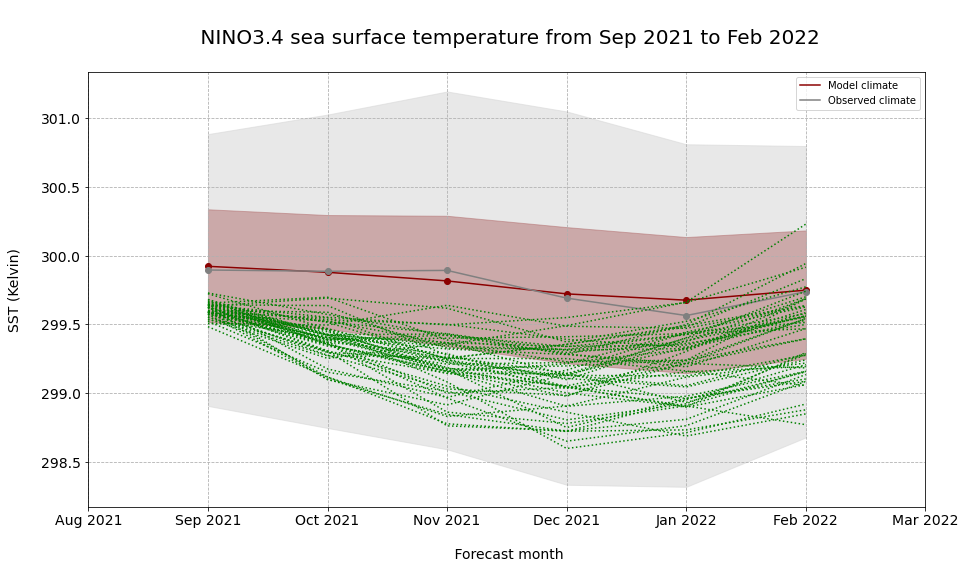

In [212]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Plot the model and obseved climate means of global sea surface temperature
ax.plot(hcst_NINO34_mean.sst, 'bo-', color='darkred', label='Model climate')
ax.fill_between(hcst_NINO34_upper.index,hcst_NINO34_lower.sst,hcst_NINO34_upper.sst, color='darkred', alpha=0.5)


ax.plot(obs_NINO34_mean.sst, 'bo-', color='grey', label= 'Observed climate')
ax.fill_between(obs_NINO34_upper.index,obs_NINO34_lower.sst,obs_NINO34_upper.sst, color='lightgrey', alpha=0.5)

ax.legend(fontsize=16,loc=2)

# Plot the global sea surface temperature forecasts for the 51 ensemble members
fcst_NINO34_mean.plot(ax=ax,
                             linestyle='dotted', color='green', legend=False, label='')



# Customize the title and axes lables
ax.set_title('\n NINO3.4 sea surface temperature from Sep 2021 to Feb 2022\n', fontsize=20)
ax.set_ylabel('SST (Kelvin)\n', fontsize=14)
ax.set_xlabel('\n Forecast month', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

locs,labels = plt.xticks()
newlabels = [(pd.to_datetime(fcst_NINO34.time.values)+relativedelta(months=int(fcmonth)-1)).strftime('%b %Y') for fcmonth in locs]
plt.xticks(locs,newlabels)

# Add a gridline to the plot
ax.grid(linestyle='--')

<br>

The graph above shows you the crucial role of hindcasts in seasonal forecasting. The grey line represents the average observed conditions and the red line represents the equivalent model climate average. The difference indicates a warm bias, which increases over time with the forecast. The ensemble forecasts are shown as green lines, which indicate even a stronger warm bias, compared to both, the model climate and the observed climate. This visual representation shows you that a forecast by itself is not useful without relating it to the relevant hindcasts.

In a next step, we can now correct the bias of the real-time seasonal forecast.

<div class="alert alert-block alert-warning">

`To Do`
    
maybe we would like to use some different data (model, region, start date,...) where the need for bias correction is more evident than it seems to be here
</div>

<br>

## <a id='bias_correction'></a>5. Correct the real-time seasonal forecast

<div class="alert alert-block alert-warning">

`To Do`
    
we want to do the bias correction grid point by grid point
- need to discuss/decide how to reconcile grids (ERA5 0.25-deg vs. seasonal 1-deg)
</div>

In [ ]:
sst_forecast_global_mean = sst_forecast_global.mean('number')
sst_forecast_global_mean

In [ ]:
sst_global_hindcast_variance = sst_hindcast_variance.mean({'latitude','longitude'})
sst_global_hindcast_variance

In [ ]:
sst_global_observation_variance = sst_observation_var.mean({'latitude', 'longitude'})
sst_global_observation_variance_roll = sst_global_observation_variance.roll(month=4, roll_coords=True)

sst_global_observation_variance_roll

<br>

The last step now is to correct the bias of the real-time seasonal forecast and

$ fcst* = (fcst - abs(hcst)) * var_{obs} / var_{hcst} + abs(obs) $

In [ ]:
forecast_corrected = (sst_forecast_global_mean - abs(model_climate_global)) * (sst_global_observation_variance_roll.values/sst_global_hindcast_variance) + abs(observed_climate_global_assigned.values)
forecast_corrected

<br>

In [ ]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Plot the model and obseved climate means of global sea surface temperature
ax.plot(model_climate_global_df.sst, 'bo-', color='darkred', label='Model climate')
ax.plot(observed_climate_global_df.sst, 'bo-', color='grey', label= 'Observed climate')
ax.plot(forecast_corrected.to_dataframe().sst, 'bo-', color='orange', label= 'Forecast - Bias-corrected')
ax.plot(sst_forecast_global_mean.to_dataframe().sst, 'bo-', color='green', label= 'Forecast')
ax.legend(fontsize=16,loc=0)





# Customize the title and axes lables
ax.set_title('\n Global sea surface temperature from Sep 2021 to Feb 2022\n', fontsize=20)
ax.set_ylabel('Kelvin\n', fontsize=14)
ax.set_xlabel('\n Forecast month', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>